## Regression Analysis On the Movie Dataset

For the Regression Analysis we will be predicting the movie Revenue based on the engineered features that we performed in the Feature engineering part of the [ Movie_DataCleaning_Wrangling_EDA_Featr_Engineering.ipynb ](Movie_DataCleaning_Wrangling_EDA_Featr_Engineering.ipynb) notebook.

## Table of Content:
* [Data Description](#Desc)
* [Utility Functions](#Utl_func)
* [Load the Data](#Load_Data)
* [Distribution of Variable](#Distrib)
* [Data Preparation for model building](#Data_Prep)
    * [Linear Regression](#Linear_Reg)
    * [RandomForest Regressor](#RF_Reg)
    * [Ridge Regression](#Ridge_Reg)
    * [Lasso Regression](#Lasso_Reg)
    * [Elasticnet Regression](#Elas_Reg)
* [Feature Selection with the best performing model](#Feat_Selec)
* [Model Comparision](#Model_Comp)
* [Model Testing with Test Data](#Model_Test)
* [Conclusion](#Conc)    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn import feature_selection,model_selection


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 50)

<a class="anchor" id="Desc"></a>

### Description of data

- **belongs_to_collection** 1 indicates a movie is a part of collection whereas 0 indicates it is not.
- **budget** total budget of the movie
- **genres** Total no of genres the movie belongs to.
- **homepage** Indicate if a movie has a homepage or not.
- **popularity** The Popularity Score assigned by TMDB.
- **id** Movie Id
- **overview** Description of the moview
- **poster_path** The path in form of html to get th poster for th movie
- **production_companies** Number of production companies collaborating to make the movie.
- **production_countries** Number of countries the film was shot in.
- **release_date** The release date of th movie
- **revenue** The revenue of the movie
- **runtime** How may time the movie ran in theater
- **spoken_languages** How many language the mmovie was release in.
- **tagline** Specific taglines to identify the type of movie
- **title** the title of the movie
- **vote_average:** The average rating of the movie.
- **vote_count:** The number of votes by users, as counted by TMDB.
- **cast** List of cast for the movie
- **return** The ratio of budget over revenue
- **year** Which year the movie was released in
- **cast_size** The total cast size of the movie
- **crew_size** The total crew size of the movie
- **director** The director info of the movie

- **is_*** All the features with is_ is either 1 or 0 explaining the feature name

<a class="anchor" id="Utl_func"></a>

### UTILITY FUNCTION

In [2]:
# initialize a dataframe for the models to be stored
cols = ['model', 'R2_Train', 'R2_Val', 'RMSE_Train', 'RMSE_Val']
cols_test = ['model', 'R2_Train', 'R2_Test', 'RMSE_Train', 'RMSE_Test']

model_df = pd.DataFrame(columns= cols)
model_test_df = pd.DataFrame(columns= cols_test)



def addScores(name, model, r2Trn, r2Val, rmseTrn, rmseVal, Test=False):
    """
    Function to store the scores to the dataframe 
    """
    # add the data to the model
    if(not Test):
        model_df.loc[name] = model, r2Trn, r2Val, rmseTrn, rmseVal
    else:
        model_test_df.loc[name] = model, r2Trn, r2Val, rmseTrn, rmseVal
        
def predictAndScore(model, X, y):
    """
    Funciton to predict and return Scores
    """
    
    # predict on the X
    y_pred = model.predict(X)
    
    # calculate R2
    r2 = r2_score(y, y_pred)
    
    # calculate the mean square error
    mse = mean_squared_error(y, y_pred)
    
    # root mean square error
    rmse = np.sqrt(mse)
    
    return r2, rmse, y_pred

def plotActualVsPred(y_train, y_pred_trn, y_val, y_pred_val):
    """
    Funciton to plot the actual vs predicted values
    Fot training and validation set
    """
    
    # Plot the Validation actual vs. predicted values
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    sns.scatterplot(x=y_train, y=y_pred_trn, ax=ax[0])
    ax[0].set_xlabel("Actual Values")
    ax[0].set_ylabel("Predicted Values")
    ax[0].set_title("Training Actual vs. Predicted Values")
    sns.scatterplot(x=y_val, y=y_pred_val, ax=ax[1])
    ax[1].set_xlabel("Actual Values")
    ax[1].set_ylabel("Predicted Values")
    ax[1].set_title("Validation Actual vs. Predicted Values")
    plt.show()
    
def plotResidualVsPred(y_train, y_pred_trn, y_val, y_pred_val):
    """
    function to plot the residual vs predicted values
    for the training and validaiton set
    """
    
    # Plot the Validation actual vs. predicted values
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    sns.scatterplot(y=(y_train-y_pred_trn), x=y_pred_trn, ax=ax[0])
    ax[0].set_ylabel("Residual Values")
    ax[0].set_xlabel("Predicted Values")
    ax[0].set_title("Training Residual vs. Predicted Values")
    sns.scatterplot(y=(y_val-y_pred_val), x=y_pred_val, ax=ax[1])
    ax[1].set_ylabel("Residual Values")
    ax[1].set_xlabel("Predicted Values")
    ax[1].set_title("Validation Residual vs. Predicted Values")
    plt.show()
    
def printMetric(r2_trn, r2_val, rmse_trn, rmse_val, test=False):
    """
    Function to print the metrix details
    """
    
    print("\nTraining Root Mean Squared Error (RMSE):", rmse_trn)
    print("Training R-squared (R2):", r2_trn)
    
    if(not test):
        print("\nValidation Root Mean Squared Error (RMSE):", rmse_val)
        print("Validation R-squared (R2):", r2_val)
    else:
        print("\nTest Root Mean Squared Error (RMSE):", rmse_val)
        print("Test R-squared (R2):", r2_val)
        


<a class="anchor" id="Load_Data"></a>

### Load the Engineered Data

In [3]:
# load the cleaned data
df = pd.read_csv("input/engineered_data.csv")
df

,belongs_to_collection,budget,genres,homepage,id,overview,popularity,poster_path,production_companies,production_countries,...,is_Mystery,is_War,is_Foreign,is_Music,is_Documentary,is_Western,is_TV Movie,is_english,is_Friday,is_Holiday
0,1,30000000.0,3,1,862,"Led by Woody, Andy's toys live happily in his ...",21.946943,<img src='http://image.tmdb.org/t/p/w185//rhIR...,1,1,...,0,0,0,0,0,0,0,1,0,0
1,0,65000000.0,3,1,8844,When siblings Judy and Peter discover an encha...,17.015539,<img src='http://image.tmdb.org/t/p/w185//vzmL...,3,1,...,0,0,0,0,0,0,0,1,1,0
2,1,NaN,2,1,15602,A family wedding reignites the ancient feud be...,11.712900,<img src='http://image.tmdb.org/t/p/w185//6ksm...,2,1,...,0,0,0,0,0,0,0,1,1,0
3,0,16000000.0,3,1,31357,"Cheated on, mistreated and stepped on, the wom...",3.859495,<img src='http://image.tmdb.org/t/p/w185//16XO...,1,1,...,0,0,0,0,0,0,0,1,1,0
4,1,NaN,1,1,11862,Just when George Banks has recovered from his ...,8.387519,<img src='http://image.tmdb.org/t/p/w185//e64s...,2,1,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45524,0,NaN,2,1,439050,Rising and falling between a man and woman.,0.072051,<img src='http://image.tmdb.org/t/p/w185//jlds...,0,1,...,0,0,0,0,0,0,0,0,0,0
45525,0,NaN,1,1,111109,An artist struggles to finish his work while a...,0.178241,<img src='http://image.tmdb.org/t/p/w185//xZkm...,1,1,...,0,0,0,0,0,0,0,0,0,1
45526,0,NaN,3,1,67758,"When one of her hits goes wrong, a professiona...",0.903007,<img src='http://image.tmdb.org/t/p/w185//d5bX...,1,1,...,0,0,0,0,0,0,0,1,1,0
45527,0,NaN,0,1,227506,"In a small town live two brothers, one a minis...",0.003503,<img src='http://image.tmdb.org/t/p/w185//aorB...,1,1,...,0,0,0,0,0,0,0,1,0,0


In [4]:
df.columns

Index(['belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'tagline', 'title', 'vote_average', 'vote_count',
       'cast', 'return', 'year', 'cast_size', 'crew_size', 'director',
       'is_Animation', 'is_Comedy', 'is_Family', 'is_Adventure', 'is_Fantasy',
       'is_Romance', 'is_Drama', 'is_Action', 'is_Crime', 'is_Thriller',
       'is_Horror', 'is_History', 'is_Science Fiction', 'is_Mystery', 'is_War',
       'is_Foreign', 'is_Music', 'is_Documentary', 'is_Western', 'is_TV Movie',
       'is_english', 'is_Friday', 'is_Holiday'],
      dtype='object')

In [5]:
# Lets clean the data from NaN
rgf = df[df['return'].notnull()]

# we dont need certain features for regression, we will be dropping them
# we are also removing since it was computed from budget and revenue
rgf.drop(['release_date', 'poster_path', 'genres', 'homepage', 'id', 'overview', 
          'tagline', 'title', 'return', 'director', 'cast'], axis=1, inplace=True)
rgf.shape

(5393, 36)

**So we are left with 5393 records and 36 feature**

In [6]:
rgf.head()

,belongs_to_collection,budget,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,vote_average,vote_count,...,is_Mystery,is_War,is_Foreign,is_Music,is_Documentary,is_Western,is_TV Movie,is_english,is_Friday,is_Holiday
0,1,30000000.0,21.946943,1,1,373554033.0,81.0,1,7.7,5415.0,...,0,0,0,0,0,0,0,1,0,0
1,0,65000000.0,17.015539,3,1,262797249.0,104.0,2,6.9,2413.0,...,0,0,0,0,0,0,0,1,1,0
3,0,16000000.0,3.859495,1,1,81452156.0,127.0,1,6.1,34.0,...,0,0,0,0,0,0,0,1,1,0
5,0,60000000.0,17.924927,3,1,187436818.0,170.0,2,7.7,1886.0,...,0,0,0,0,0,0,0,1,1,0
8,0,35000000.0,5.231580,3,1,64350171.0,106.0,1,5.5,174.0,...,0,0,0,0,0,0,0,1,1,0


**Check for multi colinearity**

<a class="anchor" id="Mult_Co_Check"></a>

In [7]:
def checkMultiColinearity(data):
    # Calculate VIF for each independent variable
    vif = pd.DataFrame()
    vif["Variable"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]

    # Sort the DataFrame by VIF values in descending order to find the highest VIF
    vif = vif.sort_values(by='VIF', ascending=False)

    # Print the variable with the highest VIF
    print("Variable with the highest VIF:")
    print(vif.iloc[0:5])

In [8]:
checkMultiColinearity(rgf)

Variable with the highest VIF:
                Variable         VIF
10                  year  109.383279
8           vote_average   69.463504
6                runtime   41.339022
33            is_english   10.813776
4   production_countries    5.299168


**As we see the year having the higest multicolinearity , lets remove it** 

In [9]:
# drop the year
rgf.drop(['year'], axis =1, inplace = True)

In [10]:
# check for multicolinearity again
checkMultiColinearity(rgf)

Variable with the highest VIF:
                Variable        VIF
8           vote_average  40.153169
6                runtime  33.443162
32            is_english   9.039021
4   production_countries   5.241654
5                revenue   5.150441


In [11]:
# lets remove vote_averge and check again
rgf.drop(['vote_average'], axis = 1, inplace= True)
checkMultiColinearity(rgf)

Variable with the highest VIF:
                Variable        VIF
6                runtime  15.536288
31            is_english   8.192326
4   production_countries   5.200500
5                revenue   5.145565
1                 budget   4.355795


**So now we have eliminated Multicolinearity to some extend  we can deal with runtime later , lets proceed ahead**

<a class="anchor" id="Distrib"></a>

### Distribution of variables

**Lets look at the distribution of some of the variables**

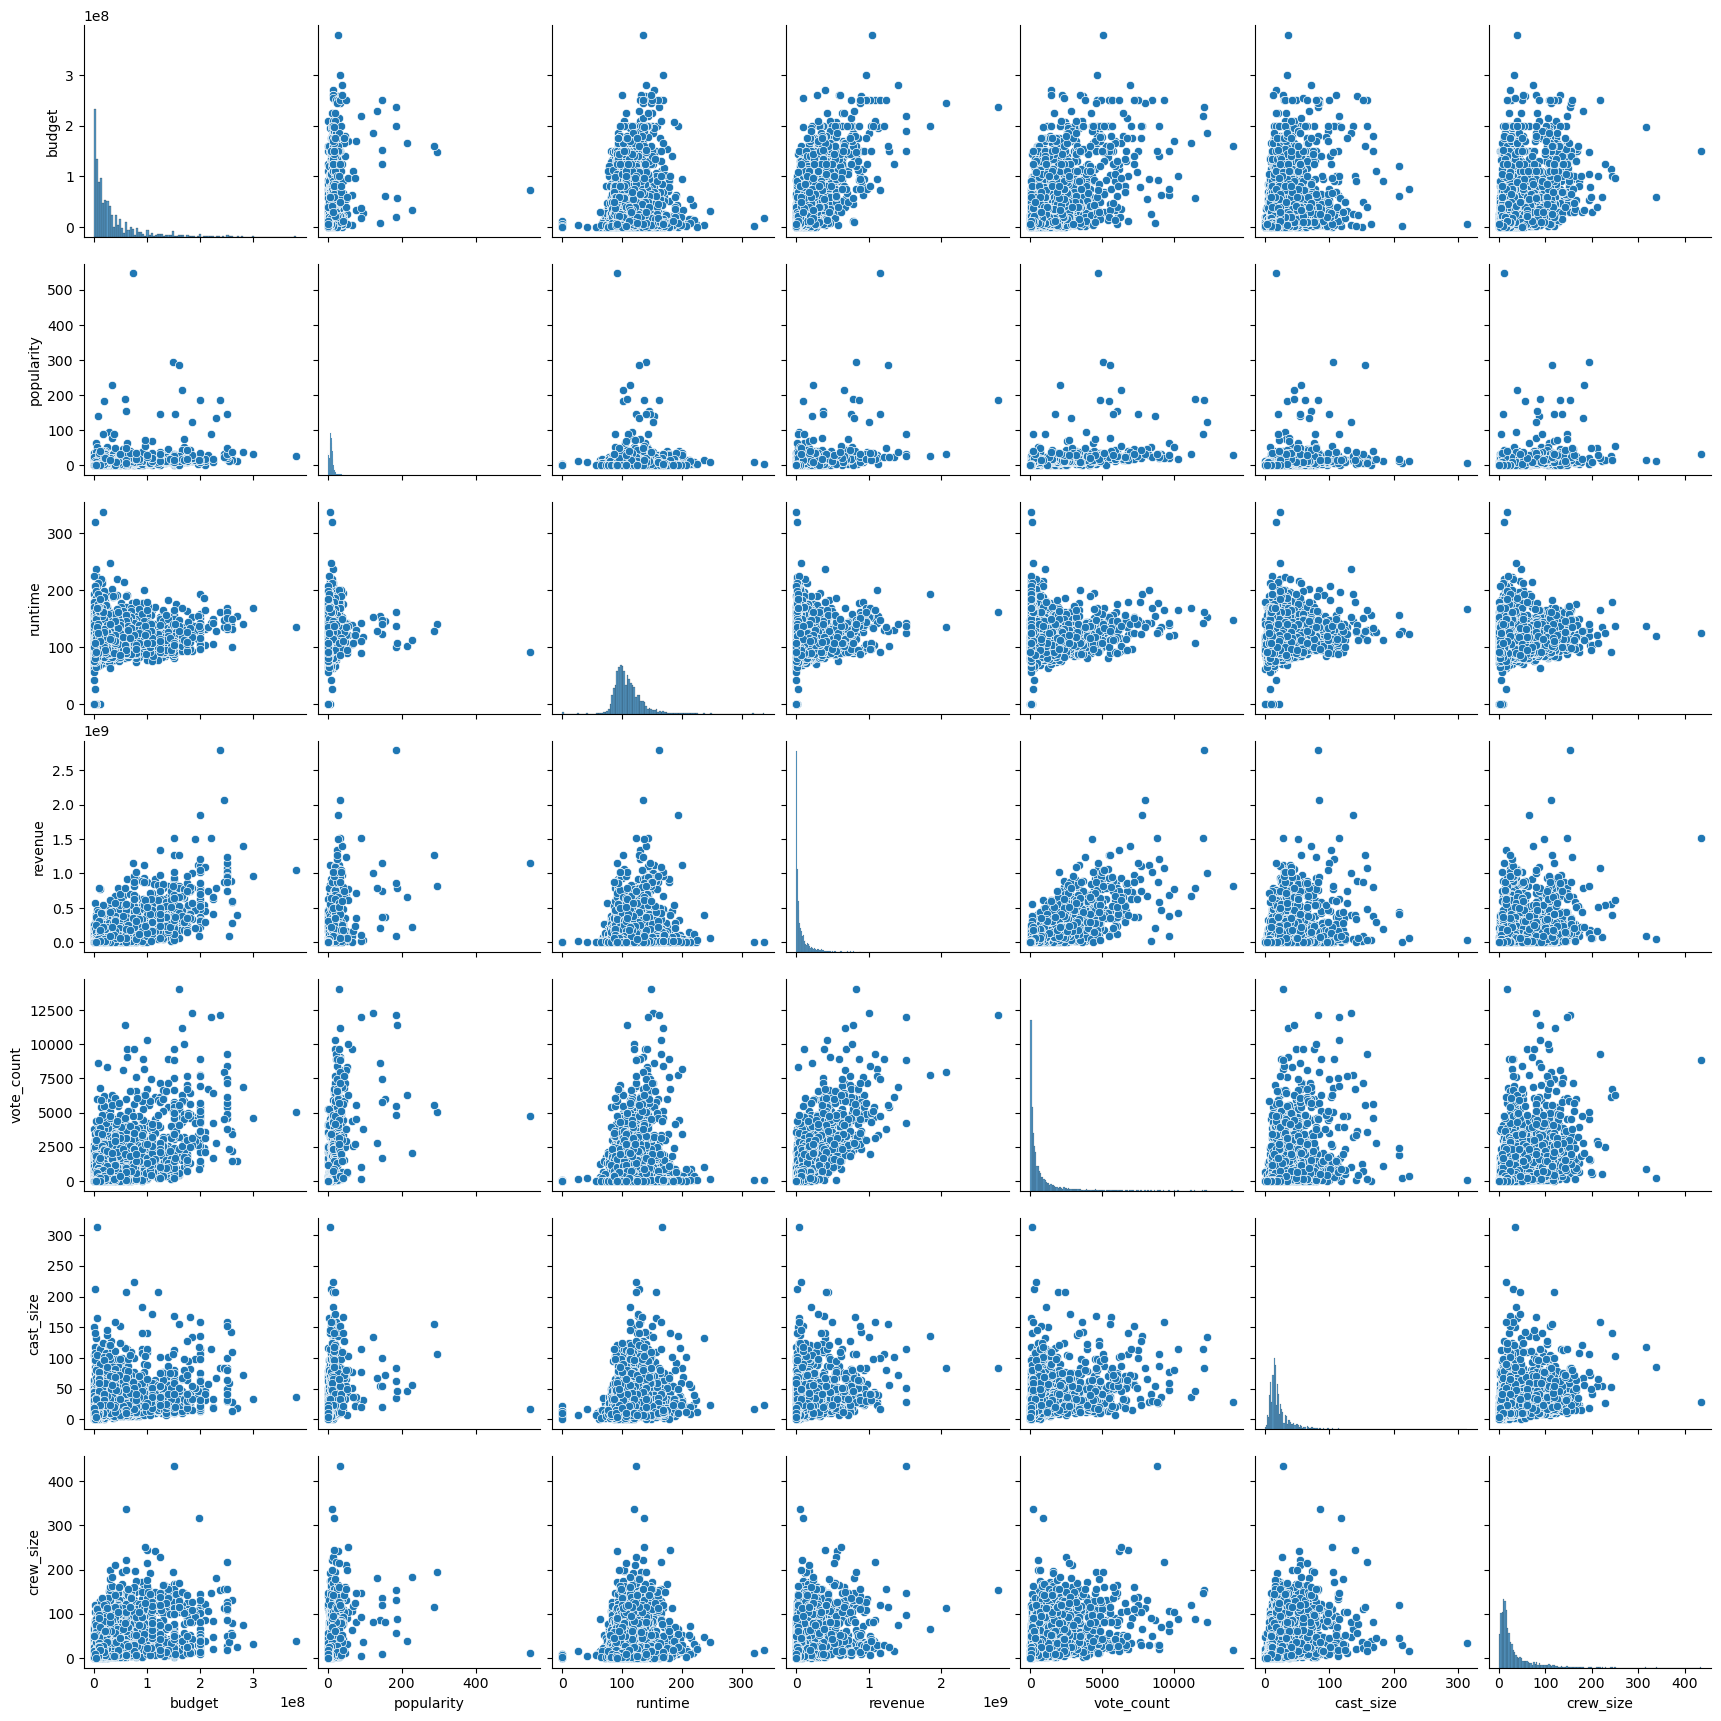

In [12]:
# lets look at the distribution of the continious variables
includeColumn = ['budget', 'popularity', 'runtime','revenue', 'vote_count', 'cast_size', 'crew_size']

sns.pairplot(rgf[includeColumn])

**We see the variables are skewed except runtime , so we will perform a trasnformation on the variables**

**As we are concentrating on the revenue , lets log transform budget and revenue to proceed with**

In [13]:
# take a backup
bck_rgf = rgf.copy()

# perform a log tranform
trans_cols = ['budget', 'revenue']

for col in trans_cols:
    bck_rgf[col] = np.log(bck_rgf[col])

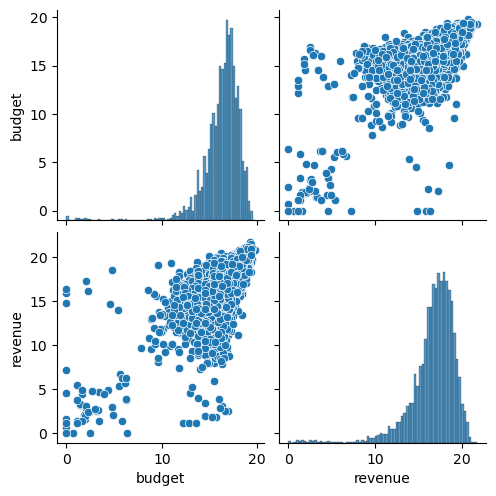

In [14]:
sns.pairplot(bck_rgf[['budget','revenue']])

### NOTE : We performed the below steps with the log transformed values but the models did not do good , hence we are not honouring the log transform and proceeding with non tranformed variables , as the models seems to learn better with the non trasformed variables.

**We are keeping this as a note that we tried it , but not showing the work on the tranformed variables**

<a class="anchor" id="Data_Prep"></a>

### Prepare the data for model building

**Since we are going to predict on the revenue, lets separate the X and y**

In [15]:
X, y = rgf.drop('revenue', axis=1), rgf['revenue']

In [16]:
# shape of the data
X.shape, y.shape

((5393, 33), (5393,))

In [17]:
RANDOM_STATE = 3010

### Split the data to train test

In [18]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=RANDOM_STATE)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3882, 33), (540, 33), (3882,), (540,))

In [20]:
# Normalize of the data
ss = MinMaxScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

In [21]:
X_train

array([[0.        , 0.06842105, 0.0244261 , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.04315789, 0.03635825, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.44736842, 0.01805993, ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.0074159 , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.00789473, 0.01995666, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.04736842, 0.01411143, ..., 1.        , 0.        ,
        0.        ]])

In [22]:
X_test

array([[0.        , 0.05      , 0.00728019, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.11842105, 0.00652228, ..., 1.        , 0.        ,
        1.        ],
       [0.        , 0.18421052, 0.03974159, ..., 1.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.01578947, 0.02428101, ..., 1.        , 1.        ,
        0.        ],
       [0.        , 0.02631579, 0.0104623 , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.03947368, 0.01494491, ..., 1.        , 1.        ,
        0.        ]])

<a class="anchor" id="Linear_Reg"></a>

### Linear Regression

In [23]:
# create the mode for linear regression
lr = LinearRegression()

# fit the model
lr.fit(X_train, y_train)

# get the r2 and rmse for train set
r2_trn, rmse_trn, y_pred_trn = predictAndScore(lr, X_train, y_train)

# get the r2 and rmse for validaiton set
r2_val, rmse_val, y_pred_val = predictAndScore(lr, X_val, y_val)

In [24]:
# Print the evaluation metrics
printMetric(r2_trn, r2_val, rmse_trn, rmse_val)

# add the score to the dataframe
addScores('LinearRegression', lr, r2_trn, r2_val, rmse_trn, rmse_val)


Training Root Mean Squared Error (RMSE): 82444448.14531817
Training R-squared (R2): 0.736607101587177

Validation Root Mean Squared Error (RMSE): 91800592.00962687
Validation R-squared (R2): 0.7614853042195449


**NOTE : We see a average R2 value as 0.73 train , 0.75 validation , with less differnce in R2 values, the rmse is in millions where the actual values are in billions**

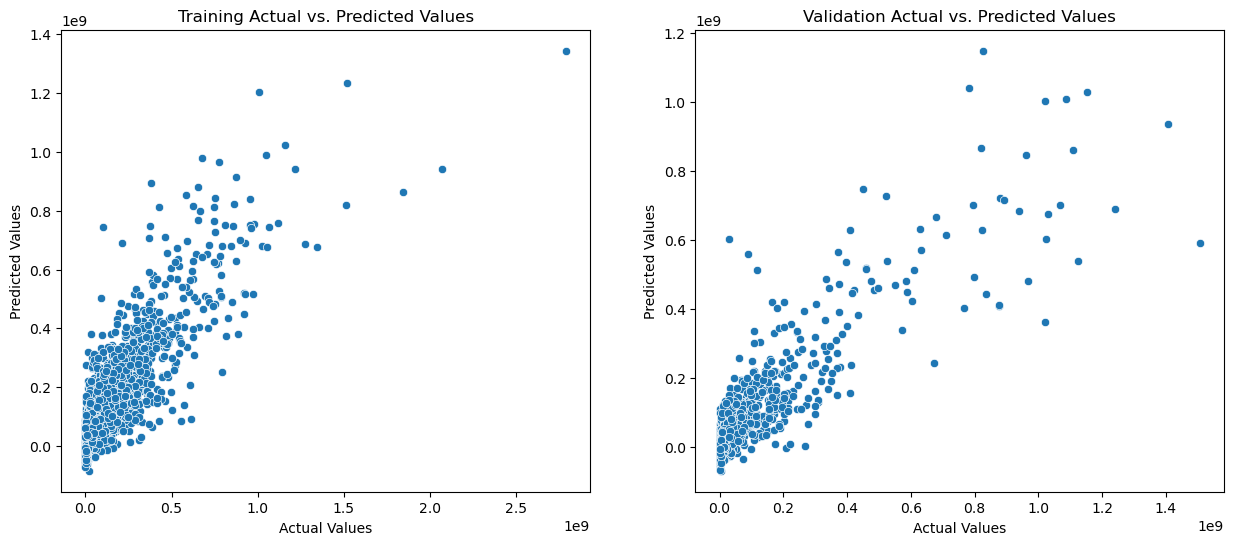

In [25]:
# plot the actual vs predicted for trainig and validation
plotActualVsPred(y_train, y_pred_trn, y_val, y_pred_val)

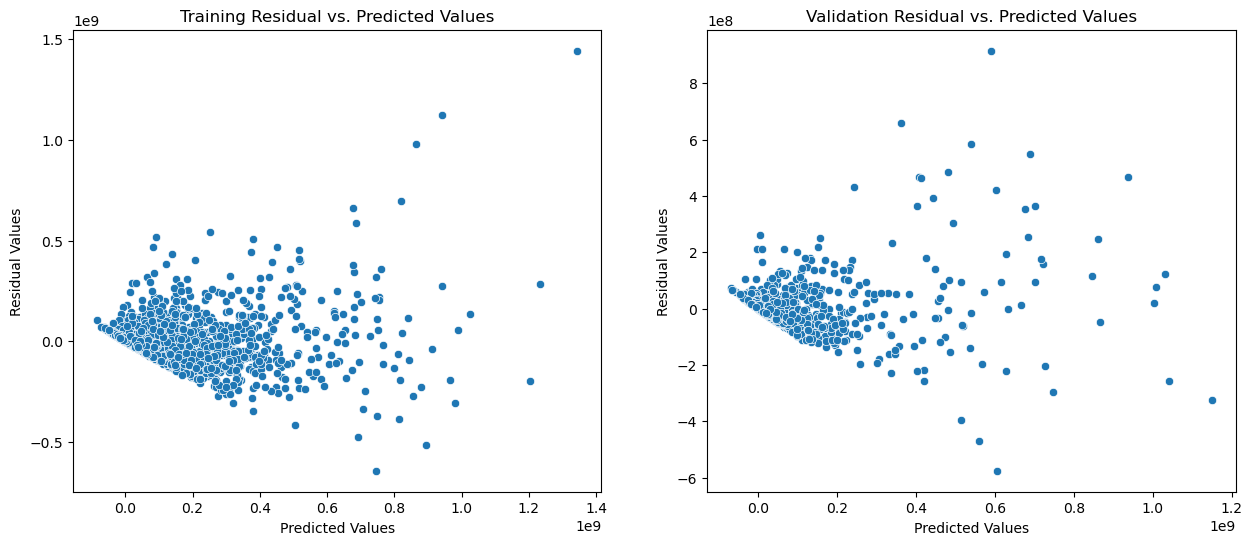

In [26]:
# show the residual plot
plotResidualVsPred(y_train, y_pred_trn, y_val, y_pred_val)

**We see a kind of randomness in the residual plot and see most of the data clubbed close to 0**

In [27]:
# get the coefficients
def getCoeff(model, data):
    w = model.coef_
    #print(w)
    #print (len(w))
    
    #create dataframe to compare var to beta coeff
    # similar to commented out code below
    names = data.columns
    newDF = names
    newDF = pd.DataFrame(newDF)
    newDF['Betas'] = w
    newDF.columns = ['Var','BetaCoeff']
    newDF
    
    return newDF

newDF = getCoeff(lr, X)
newDF

,Var,BetaCoeff
0,belongs_to_collection,4.509426e+07
1,budget,5.834312e+08
2,popularity,5.246086e+08
3,production_companies,-9.691577e+07
4,production_countries,-4.490049e+07
5,runtime,6.356829e+07
6,spoken_languages,2.004439e+07
7,vote_count,8.099981e+08
8,cast_size,1.474323e+07
9,crew_size,-2.694086e+07


In [28]:
# The following function can be used to plot the model coefficients for better visualization
%matplotlib inline
def plot_coefficients(model, n_features, feature_names):
    plt.figure(figsize=(10,8))
    plt.barh(range(n_features), model.coef_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

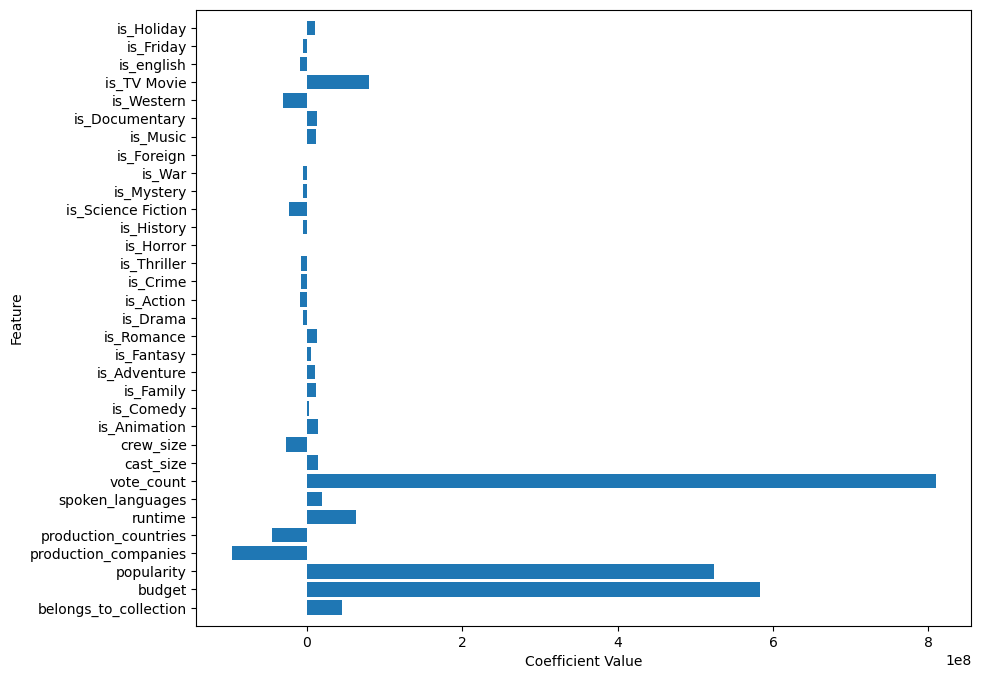

In [29]:
# USE variables from dataframe create above to plot
plot_coefficients(lr, len(newDF.Var), newDF.Var)

**NOTE : We see  vote_count, bugdet and popularity has the highest beta coefficient to drive the prediction of revenue, which kind of makes sense as the votecount is how people liked the movie , budget is the total amount spend in making the moview and popularity is how people liked it**

**Surprisingly is_holiday and is_friday do not play much of importance for the prediction of revenue**

### Let's perform some cross validation to check the scores.

In [30]:
# perform cross validation and 
# get the cross validation scores
cv_scores = cross_val_score(lr, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
print(np.sqrt(abs(cv_scores)))

[7.04318437e+07 8.61651876e+07 8.17647773e+07 6.69753139e+07
 9.10660038e+07 8.56006059e+07 9.84250765e+07 1.03959508e+08
 8.09898512e+07 6.71725503e+07]


In [31]:
# Computing the RMSE on the training data
p_train = lr.predict(X_train) # p_train is the array of predicted training values
rmse_train = np.sqrt(mean_squared_error(p_train, y_train))

In [32]:
method_name = 'Simple Linear Regression'
print('Method: %s' %method_name)
print('RMSE on training: %.4f' %rmse_train)
print('RMSE on 10-fold CV: %.4f' %np.sqrt(abs(cv_scores)).mean())

Method: Simple Linear Regression
RMSE on training: 82444448.1453
RMSE on 10-fold CV: 83255071.8110


**The RMSE on train and 10 fold CV is simillar , which is pretty decent as our scale of revenue is in billions**

<a class="anchor" id="RF_Reg"></a>

### RandomForest Regressor

In [33]:
# get the model with 100 trees
estimator = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)

In [34]:
# fit the model
estimator.fit(X_train, y_train)

# get the r2 and rmse for train set
r2_trn, rmse_trn, y_pred_trn = predictAndScore(estimator, X_train, y_train)

# get the r2 and rmse for validaiton set
r2_val, rmse_val, y_pred_val = predictAndScore(estimator, X_val, y_val)

In [35]:
# Print the evaluation metrics
printMetric(r2_trn, r2_val, rmse_trn, rmse_val)

if 'RandomForestRegressor' in model_test_df.index:
    model_df.drop('RandomForestRegressor', inplace=True)

# add the score to the dataframe
addScores('RandomForestRegressor', estimator, r2_trn, r2_val, rmse_trn, rmse_val)


Training Root Mean Squared Error (RMSE): 29871907.58961871
Training R-squared (R2): 0.9654214207758173

Validation Root Mean Squared Error (RMSE): 88949548.99905148
Validation R-squared (R2): 0.7760703095684037


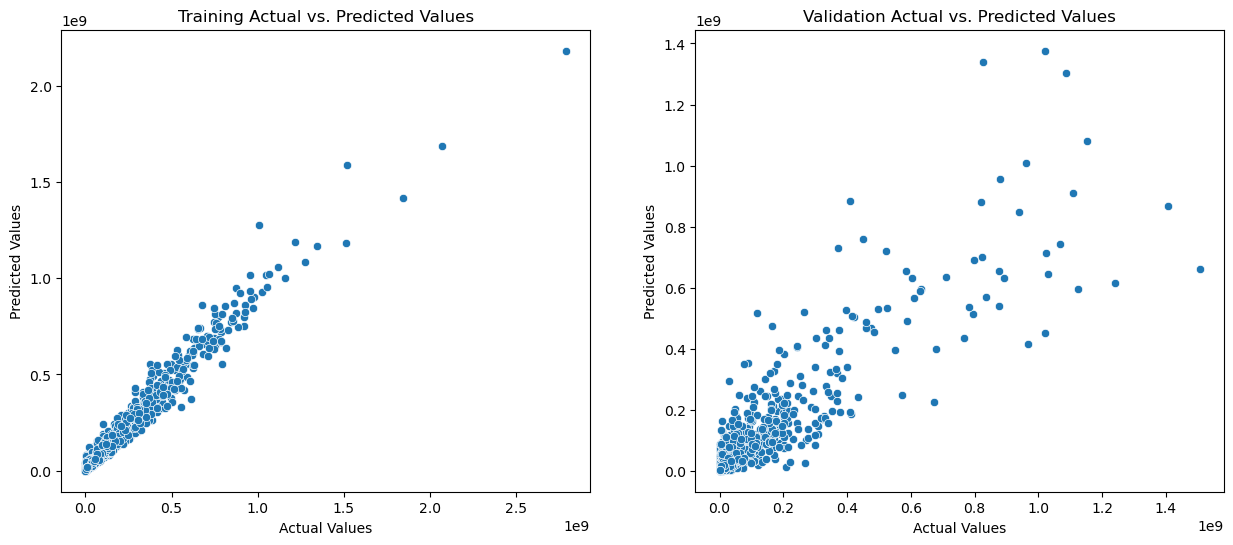

In [36]:
# plot the actual vs predicted for trainig and validation
plotActualVsPred(y_train, y_pred_trn, y_val, y_pred_val)

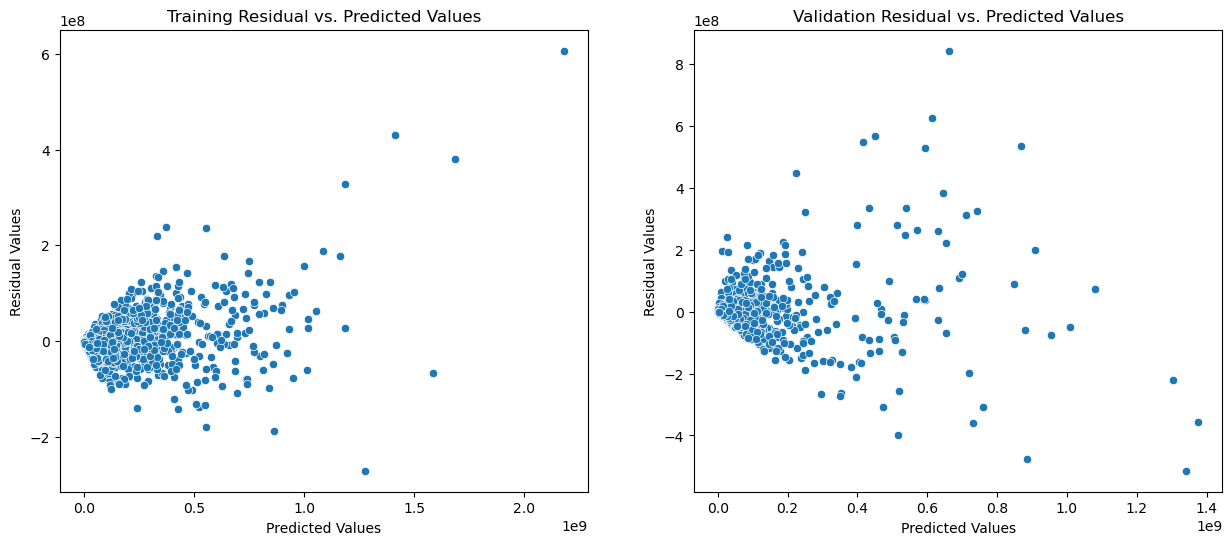

In [37]:
plotResidualVsPred(y_train, y_pred_trn, y_val, y_pred_val)

**With cross validation it seems like its overfitting with higher RMSE and lower R2 in the validation**

### Hyperparameter tunning
**We see a diffference between the RMSE train and validation , so lets perform some hyper parameter tuning**

In [38]:
# create the model
rfr = RandomForestRegressor(random_state=RANDOM_STATE)

# hyper parameters
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth' : [8, 16, 32, 50, None],
}

# perform a grid search
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# fit the model and get the best params and estimator
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [39]:
print(f"\nBest Params :: {best_params}")
print(f"Best Model :: {best_model}")


Best Params :: {'max_depth': 16, 'n_estimators': 150}
Best Model :: RandomForestRegressor(max_depth=16, n_estimators=150, random_state=3010)


In [40]:
# get the r2 and rmse for train set
r2_trn, rmse_trn, y_pred_trn = predictAndScore(best_model, X_train, y_train)

# get the r2 and rmse for validaiton set
r2_val, rmse_val, y_pred_val = predictAndScore(best_model, X_val, y_val)

In [41]:
# Print the evaluation metrics
printMetric(r2_trn, r2_val, rmse_trn, rmse_val)

if 'RandomForestRegressor_hypTune' in model_test_df.index:
    model_df.drop('RandomForestRegressor_hypTune', inplace=True)

# add the score to the dataframe
addScores('RandomForestRegressor_hypTune', best_model, r2_trn, r2_val, rmse_trn, rmse_val)


Training Root Mean Squared Error (RMSE): 29565021.677905943
Training R-squared (R2): 0.9661282500798549

Validation Root Mean Squared Error (RMSE): 89399756.5002028
Validation R-squared (R2): 0.7737977863551514


**Even with the hyper parameter tuning we still see a difference between the training and validation showing signs of overfitting**

**Till now we have seen that the LinearRegression model has given a descent result**

<a class="anchor" id="Ridge_Reg"></a>

### Regression with ridge regularization

**Lets introduce some regularization and see if we can overcome some overfittin**

In [42]:
# Create linear regression object with a ridge coefficient 0.5
ridge = Ridge(alpha=0.5)

# fit the model
ridge.fit(X_train, y_train)

# get the r2 and rmse for train set
r2_trn, rmse_trn, y_pred_trn = predictAndScore(ridge, X_train, y_train)

# get the r2 and rmse for validaiton set
r2_val, rmse_val, y_pred_val = predictAndScore(ridge, X_val, y_val)

In [43]:
# Print the evaluation metrics
printMetric(r2_trn, r2_val, rmse_trn, rmse_val)

# add the score to the dataframe
addScores('RidgeRegession', ridge, r2_trn, r2_val, rmse_trn, rmse_val)


Training Root Mean Squared Error (RMSE): 82484873.18046422
Training R-squared (R2): 0.7363487390690541

Validation Root Mean Squared Error (RMSE): 91645200.63929789
Validation R-squared (R2): 0.762292091106894


**We see pretty simillar result like the linear regression with Ridge at alpha  =0.5 , so lets perform some paramter tuning with cross validaiton**

In [44]:
from sklearn.model_selection import KFold

def cross_validate(model, X, y, n, verbose=False):
    # model: regression model to be trained
    # X: the training data matrix
    # y: the training target variable array
    # n: the number of fold for x-validation
    # Returns mean RMSE across all folds
    
    kf = KFold(n_splits=n) 
                                            
    xval_err = 0
    xtrn_err = 0
    f = 1
    for train,test in kf.split(X):
        model.fit(X[train],y[train]) # fit model to the training partition in this fold
        
        p_train = model.predict(X[train])
        rmse_train = np.sqrt(mean_squared_error(p_train, y[train]))
        xtrn_err += rmse_train
        
        p_test = model.predict(X[test]) # apply trained model to test partition in this fold
        rmse_test = np.sqrt(mean_squared_error(p_test, y[test]))
        if verbose:
            print("Fold %2d RMSE: %.4f" % (f, rmse_test))
        xval_err += rmse_test
        f += 1
        
    return xval_err/n, xtrn_err/n

In [45]:
# functiom to perform cross validation to find optimal parameter
def performCrossVal(model_name, X_train, y_train, alpha):
    t_rmse = np.array([])
    cv_rmse = np.array([])

    for a in alpha:
        if model_name == 'ridge':
            model = Ridge(alpha=a)
        elif model_name == 'lasso':
            model = Lasso(alpha=a)
        elif model_name == 'elastic':
            model = ElasticNet(alpha=a, l1_ratio=0.5)
    
        # Compute RMSE using 10-fold x-validation 
        rmse_10cv, rmse_train = cross_validate(model, X_train, y_train.values, 10)
    
        gap = abs(rmse_10cv - rmse_train)
    
        t_rmse = np.append(t_rmse, [rmse_train])
        cv_rmse = np.append(cv_rmse, [rmse_10cv])
    
        print('{:.3f}\t {:.4f}\t\t {:.4f}\t\t {:.4f}'.format(a,rmse_train,rmse_10cv,gap))
        
    return t_rmse, cv_rmse

**Find optimal alpha for Ridge Regression**

In [75]:
alpha = np.linspace(.001,4.0,30)

print('Ridge Regression')
print('alpha\t RMSE_train\t\t RMSE_10cv\t\t Gap\n')
t_rmse, cv_rmse = performCrossVal('ridge',X_train, y_train, alpha)

Ridge Regression
alpha	 RMSE_train		 RMSE_10cv		 Gap

0.001	 82347147.6269		 83254912.8693		 907765.2423
0.139	 82352347.5914		 83244827.7530		 892480.1616
0.277	 82365053.5382		 83246702.4294		 881648.8912
0.415	 82382725.4044		 83252905.9079		 870180.5035
0.553	 82403942.0258		 83260983.7639		 857041.7381
0.690	 82427846.6818		 83270135.1799		 842288.4980
0.828	 82453897.1540		 83280133.4258		 826236.2718
0.966	 82481737.4979		 83290955.3943		 809217.8964
1.104	 82511126.6761		 83302645.1075		 791518.4314
1.242	 82541896.6188		 83315261.8099		 773365.1911
1.380	 82573926.6130		 83328860.6122		 754933.9992
1.518	 82607127.2099		 83343486.1169		 736358.9070
1.656	 82641429.8906		 83359171.2476		 717741.3570
1.794	 82676780.3130		 83375938.0716		 699157.7586
1.932	 82713133.8398		 83393799.2726		 680665.4328
2.069	 82750452.5438		 83412759.7162		 662307.1724
2.207	 82788703.1862		 83432817.8911		 644114.7049
2.345	 82827855.8437		 83453967.1590		 626111.3153
2.483	 82867882.9712		 83476

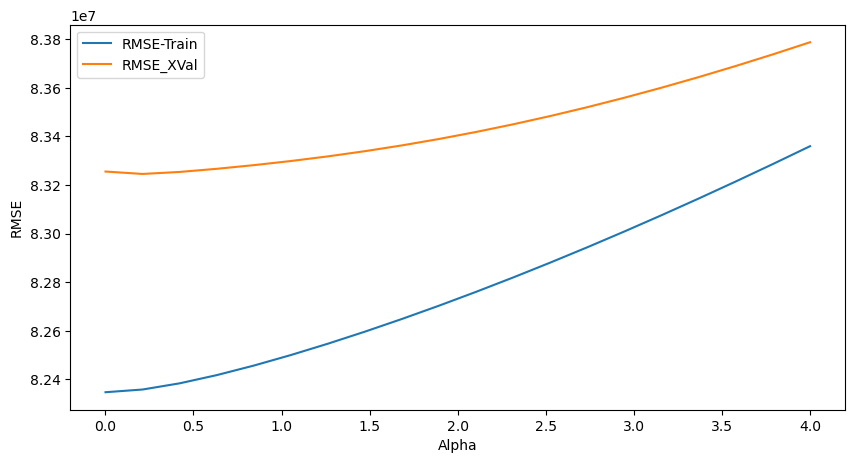

In [74]:
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alpha, t_rmse, label='RMSE-Train')
ax.plot(alpha, cv_rmse, label='RMSE_XVal')
pl.legend( ('RMSE-Train', 'RMSE_XVal') )
pl.ylabel('RMSE')
pl.xlabel('Alpha')
pl.show()

**We see alpha at 0.1 has a better performance then all other value with less RMSE CV and less difference**

In [76]:
# Create linear regression object with a ridge coefficient 0.1
ridge = Ridge(alpha=0.1)

# Train the model using the training set
ridge.fit(X_train, y_train)


# get the r2 and rmse for train set
r2_trn, rmse_trn, y_pred_trn = predictAndScore(ridge, X_train, y_train)

# get the r2 and rmse for validaiton set
r2_val, rmse_val, y_pred_val = predictAndScore(ridge, X_val, y_val)


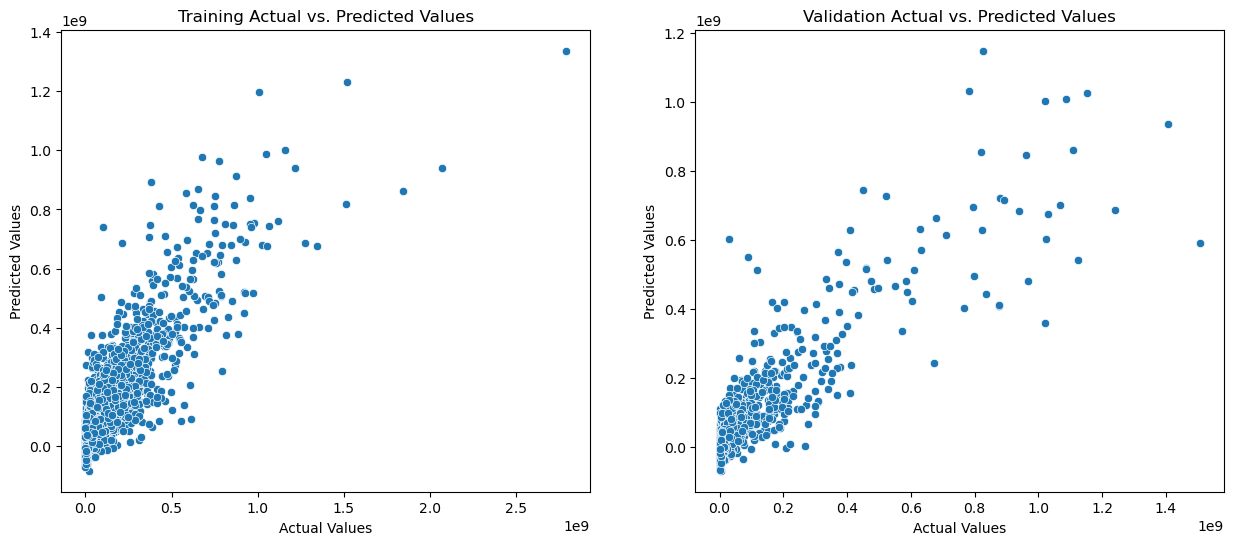

In [77]:
plotActualVsPred(y_train, y_pred_trn, y_val, y_pred_val)

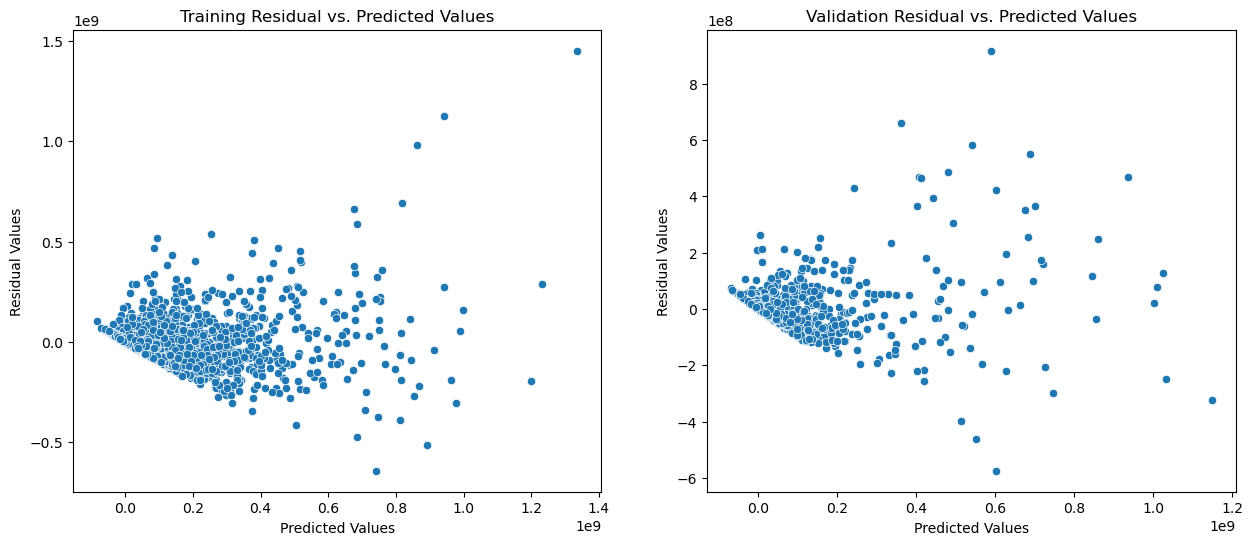

In [78]:
plotResidualVsPred(y_train, y_pred_trn, y_val, y_pred_val)

In [49]:
# Print the evaluation metrics
printMetric(r2_trn, r2_val, rmse_trn, rmse_val)

# add the score to the dataframe
addScores('RidgeRegession_tune', ridge, r2_trn, r2_val, rmse_trn, rmse_val)


Training Root Mean Squared Error (RMSE): 82446666.65488148
Training R-squared (R2): 0.7365929260413586

Validation Root Mean Squared Error (RMSE): 91751044.04271936
Validation R-squared (R2): 0.7617427040624967


**With tunning and alpha selection also we see similar result**

<a class="anchor" id="Lasso_Reg"></a>

### Lasso Regression

**We perform a cross validation to find our alpha to fit the model to measure model accuraccy**

**Find optimal alpha for Lasso Regression**

In [50]:
alpha = np.linspace(.001,4.0,100)

print('Lasso Regression')
print('alpha\t RMSE_train\t\t RMSE_10cv\t\t Gap\n')
t_rmse, cv_rmse = performCrossVal('lasso',X_train, y_train, alpha)

Lasso Regression
alpha	 RMSE_train		 RMSE_10cv		 Gap

0.001	 82347147.3066		 83255071.8097		 907924.5030
0.041	 82347147.3066		 83255071.7557		 907924.4490
0.082	 82347147.3066		 83255071.7013		 907924.3947
0.122	 82347147.3066		 83255071.6472		 907924.3406
0.163	 82347147.3066		 83255071.5937		 907924.2870
0.203	 82347147.3066		 83255071.5394		 907924.2327
0.243	 82347147.3066		 83255071.4853		 907924.1786
0.284	 82347147.3066		 83255071.4316		 907924.1250
0.324	 82347147.3066		 83255071.3777		 907924.0711
0.365	 82347147.3066		 83255071.3234		 907924.0168
0.405	 82347147.3066		 83255071.2605		 907923.9538
0.445	 82347147.3066		 83255071.2113		 907923.9047
0.486	 82347147.3066		 83255071.1581		 907923.8514
0.526	 82347147.3067		 83255071.1054		 907923.7988
0.567	 82347147.3067		 83255071.0481		 907923.7415
0.607	 82347147.3067		 83255070.9942		 907923.6876
0.647	 82347147.3067		 83255070.9469		 907923.6402
0.688	 82347147.3067		 83255070.8917		 907923.5851
0.728	 82347147.3067		 83255

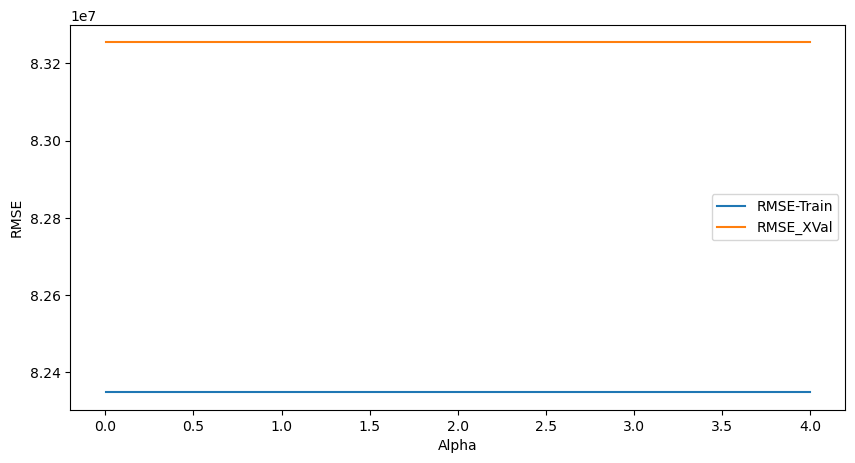

In [51]:
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alpha, t_rmse, label='RMSE-Train')
ax.plot(alpha, cv_rmse, label='RMSE_XVal')
pl.legend( ('RMSE-Train', 'RMSE_XVal') )
pl.ylabel('RMSE')
pl.xlabel('Alpha')
pl.show()

**As we see alpha at 0.001 perform better , so lets proceed further see the results**

In [79]:
# Let's pick 0.001 for lasso regularization coefficient
lasso = Lasso(alpha=0.001)

# Train the model using the training set
lasso.fit(X_train, y_train)

# get the r2 and rmse for train set
r2_trn, rmse_trn, y_pred_trn = predictAndScore(lasso, X_train, y_train)

# get the r2 and rmse for validaiton set
r2_val, rmse_val, y_pred_val = predictAndScore(lasso, X_val, y_val)


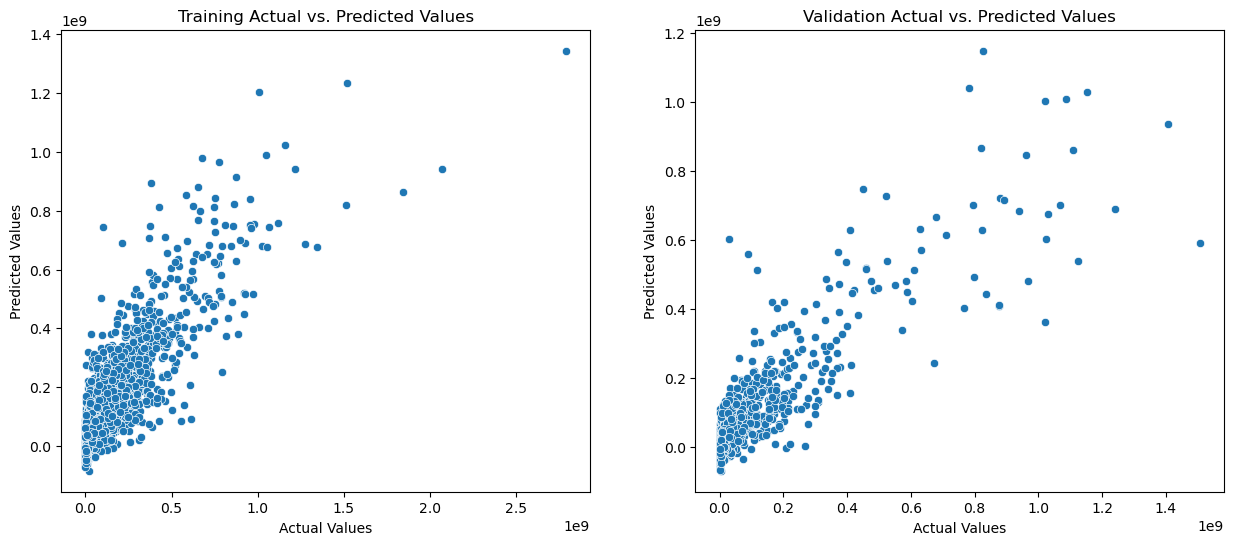

In [81]:
plotActualVsPred(y_train, y_pred_trn, y_val, y_pred_val)

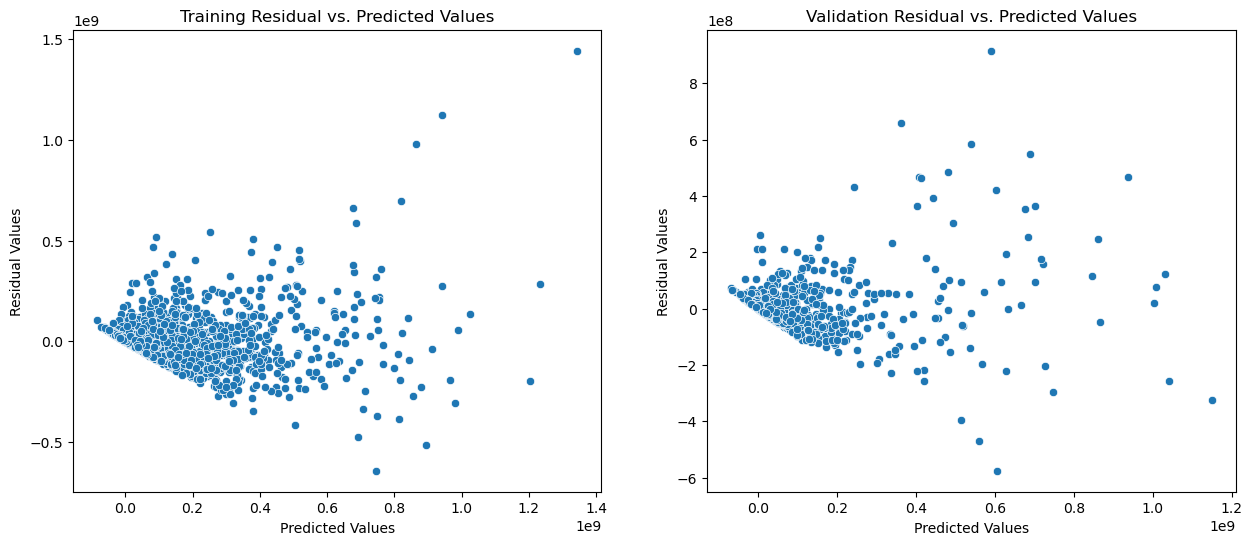

In [82]:
plotResidualVsPred(y_train, y_pred_trn, y_val, y_pred_val)

In [80]:
# Print the evaluation metrics
printMetric(r2_trn, r2_val, rmse_trn, rmse_val)

# add the score to the dataframe
addScores('LassoRegession', lasso, r2_trn, r2_val, rmse_trn, rmse_val)


Training Root Mean Squared Error (RMSE): 82444448.14531817
Training R-squared (R2): 0.736607101587177

Validation Root Mean Squared Error (RMSE): 91800592.00808339
Validation R-squared (R2): 0.7614853042275653


<a class="anchor" id="Elas_Reg"></a>

### Elasticnet Regression

**Find optimal value of alpha for Elastic Regression**

In [54]:
alpha = np.linspace(.001,1.0,10) # create an array of 100 evenly spaced numbers between 0.01 and 5.0

print('Elastic Net Regression')
print('alpha\t RMSE_train\t\t RMSE_10cv\t\t Gap\n')
t_rmse, cv_rmse = performCrossVal('elastic',X_train, y_train, alpha)

Elastic Net Regression
alpha	 RMSE_train		 RMSE_10cv		 Gap

0.001	 82664681.3539		 83370115.3988		 705434.0450
0.112	 122832824.0414		 121751629.6058		 1081194.4356
0.223	 131496575.6637		 130237005.0702		 1259570.5934
0.334	 135860676.1211		 134480552.4161		 1380123.7050
0.445	 138739482.6735		 137276078.2776		 1463404.3958
0.556	 140875490.5342		 139352323.6363		 1523166.8978
0.667	 142563169.2346		 140995651.0956		 1567518.1391
0.778	 143948794.2199		 142347427.4076		 1601366.8123
0.889	 145116156.8065		 143488346.3148		 1627810.4916
1.000	 146118123.4057		 144469242.9944		 1648880.4112


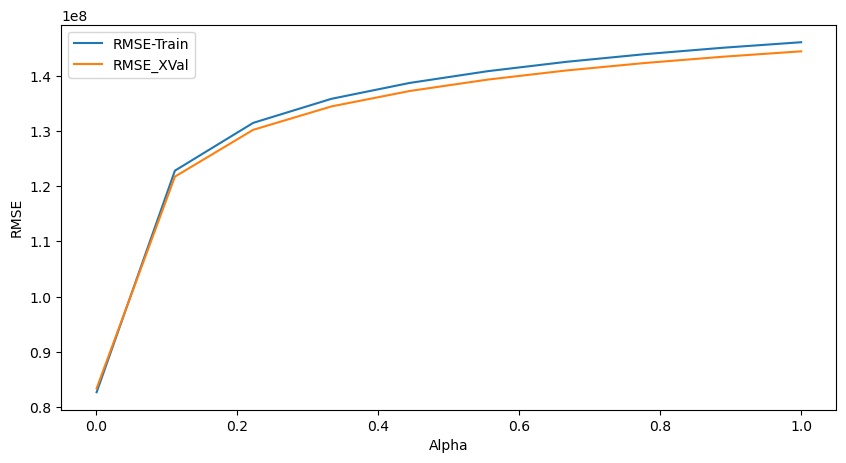

In [55]:
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(alpha, t_rmse, label='RMSE-Train')
ax.plot(alpha, cv_rmse, label='RMSE_XVal')
pl.legend( ('RMSE-Train', 'RMSE_XVal') )
pl.ylabel('RMSE')
pl.xlabel('Alpha')
pl.show()

**The lowest value of RMSE CV we see at alpha 0.001, rest ohters we see overfitting**

In [83]:
# Let's pick 0.3 for lasso regularization coefficient
elastic = ElasticNet(alpha=0.001, l1_ratio=0.5)

# Train the model using the training set
elastic.fit(X_train, y_train)

# get the r2 and rmse for train set
r2_trn, rmse_trn, y_pred_trn = predictAndScore(elastic, X_train, y_train)

# get the r2 and rmse for validaiton set
r2_val, rmse_val, y_pred_val = predictAndScore(elastic, X_val, y_val)


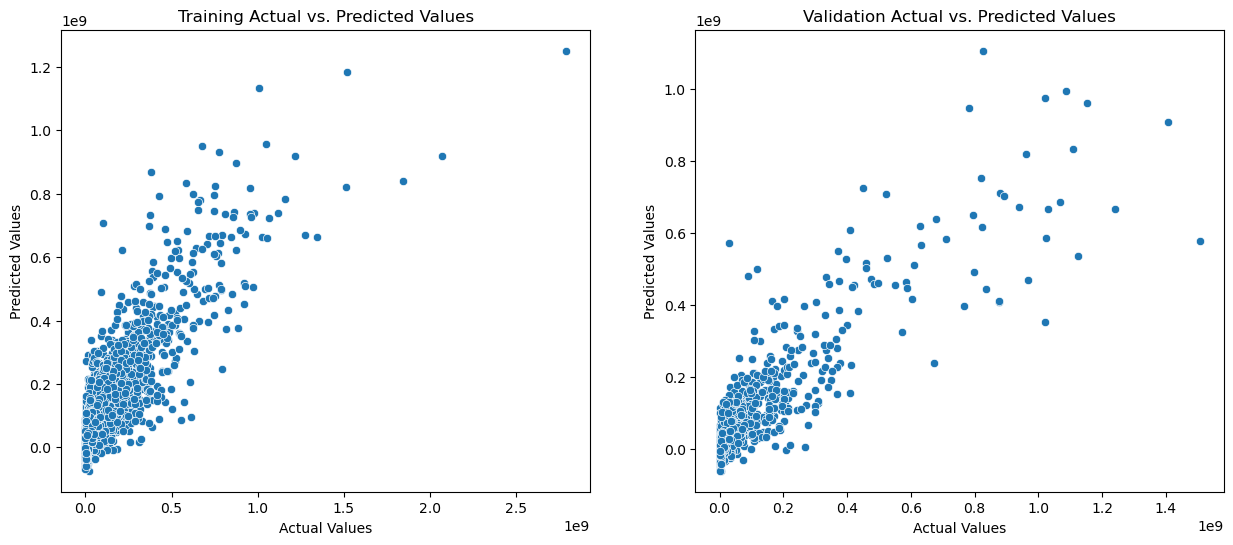

In [84]:
plotActualVsPred(y_train, y_pred_trn, y_val, y_pred_val)

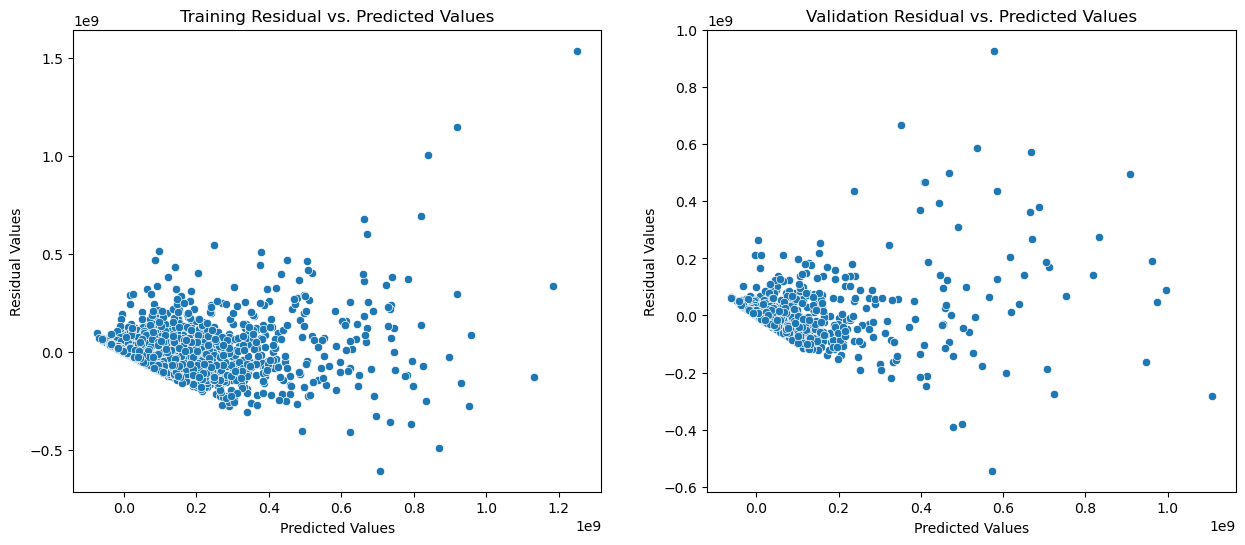

In [85]:
plotResidualVsPred(y_train, y_pred_trn, y_val, y_pred_val)

In [57]:
# Print the evaluation metrics
printMetric(r2_trn, r2_val, rmse_trn, rmse_val)

# add the score to the dataframe
addScores('ElasticNet', elastic, r2_trn, r2_val, rmse_trn, rmse_val)


Training Root Mean Squared Error (RMSE): 82762908.98857002
Training R-squared (R2): 0.734568339000963

Validation Root Mean Squared Error (RMSE): 91767442.33742896
Validation R-squared (R2): 0.7616575309173048


**Even in elastic net we see similar result**

In [58]:
model_df

,model,R2_Train,R2_Val,RMSE_Train,RMSE_Val
LinearRegression,LinearRegression(),0.736607,0.761485,8.244445e+07,9.180059e+07
RandomForestRegressor,"(DecisionTreeRegressor(max_features=1.0, rando...",0.965421,0.776070,2.987191e+07,8.894955e+07
RandomForestRegressor_hypTune,"(DecisionTreeRegressor(max_depth=16, max_featu...",0.966128,0.773798,2.956502e+07,8.939976e+07
RidgeRegession,Ridge(alpha=0.5),0.736349,0.762292,8.248487e+07,9.164520e+07
RidgeRegession_tune,Ridge(alpha=0.1),0.736593,0.761743,8.244667e+07,9.175104e+07
LassoRegession,Lasso(alpha=0.001),0.736607,0.761485,8.244445e+07,9.180059e+07
ElasticNet,ElasticNet(alpha=0.001),0.734568,0.761658,8.276291e+07,9.176744e+07


<a class="anchor" id="Feat_Selec"></a>

**Since we see the Linear Regressiom model performed the best , lets perform some feature selection and rerun LinearRegression to see if we can increase the performance**

In [59]:
# Perform feature selection using SelectKBest with F value for regession
# In this experiment, we'll select the top 10 features out of total 34 
# as we saw only few features in the feature importance.
k_best = SelectKBest(score_func=f_regression, k=10)
X_train_selected = k_best.fit_transform(X_train, y_train)
X_val_selected = k_best.transform(X_val)
X_test_selected = k_best.transform(X_test)

In [60]:
# create the mode for linear regression
lr_kbest = LinearRegression()

# fit the model
lr_kbest.fit(X_train_selected, y_train)

# get the r2 and rmse for train set
r2_trn, rmse_trn, y_pred_trn = predictAndScore(lr_kbest, X_train_selected, y_train)

# get the r2 and rmse for validaiton set
r2_val, rmse_val, y_pred_val = predictAndScore(lr_kbest, X_val_selected, y_val)

In [61]:
# Print the evaluation metrics
printMetric(r2_trn, r2_val, rmse_trn, rmse_val)

# add the score to the dataframe
addScores('LinearRegression_kbest', lr_kbest, r2_trn, r2_val, rmse_trn, rmse_val)


Training Root Mean Squared Error (RMSE): 84576554.9842469
Training R-squared (R2): 0.7228076673344253

Validation Root Mean Squared Error (RMSE): 93359071.47433794
Validation R-squared (R2): 0.7533181332734018


<a class="anchor" id="Model_Comp"></a>

### Model Comparision

In [62]:
model_df

,model,R2_Train,R2_Val,RMSE_Train,RMSE_Val
LinearRegression,LinearRegression(),0.736607,0.761485,8.244445e+07,9.180059e+07
RandomForestRegressor,"(DecisionTreeRegressor(max_features=1.0, rando...",0.965421,0.776070,2.987191e+07,8.894955e+07
RandomForestRegressor_hypTune,"(DecisionTreeRegressor(max_depth=16, max_featu...",0.966128,0.773798,2.956502e+07,8.939976e+07
RidgeRegession,Ridge(alpha=0.5),0.736349,0.762292,8.248487e+07,9.164520e+07
RidgeRegession_tune,Ridge(alpha=0.1),0.736593,0.761743,8.244667e+07,9.175104e+07
LassoRegession,Lasso(alpha=0.001),0.736607,0.761485,8.244445e+07,9.180059e+07
ElasticNet,ElasticNet(alpha=0.001),0.734568,0.761658,8.276291e+07,9.176744e+07
LinearRegression_kbest,LinearRegression(),0.722808,0.753318,8.457655e+07,9.335907e+07


**Even after feature selection we see the simple Linear Regression model doing the best**

<a class="anchor" id="Model_Test"></a>

### Model Testing
**Lets test the model with the testing data**

In [63]:
# best regressor model
best2_reg = model_df.loc["LinearRegression"]
best2_reg

model         LinearRegression()
R2_Train                0.736607
R2_Val                  0.761485
RMSE_Train       82444448.145318
RMSE_Val         91800592.009627
Name: LinearRegression, dtype: object

In [64]:
# get the model object
model1_reg = best2_reg[0]
model1_reg

LinearRegression()

In [65]:
# get the r2 and rmse for train set
r2_trn, rmse_trn, y_pred_trn = predictAndScore(model1_reg, X_train, y_train)

# get the r2 and rmse for test set
r2_test, rmse_test, y_pred_test = predictAndScore(model1_reg, X_test, y_test)

In [66]:
# Print the evaluation metrics
printMetric(r2_trn, r2_test, rmse_trn, rmse_test, True)

if 'LinearRegression' in model_test_df.index:
    model_df.drop('LinearRegression', inplace=True)

# add the score to dataframe
addScores("LinearRegression", model1_reg, r2_trn, r2_test, rmse_trn, rmse_test, True )


Training Root Mean Squared Error (RMSE): 82444448.14531817
Training R-squared (R2): 0.736607101587177

Test Root Mean Squared Error (RMSE): 74281313.55508779
Test R-squared (R2): 0.7869511475469184


**We see the model performing decent on the test data and has lowered the RMSE a bit than the validation, This can be a decenst model to predict the revenue of a movie** 

In [ ]:
<a class="anchor" id="Test_Result"></a>

In [67]:
model_test_df

,model,R2_Train,R2_Test,RMSE_Train,RMSE_Test
LinearRegression,LinearRegression(),0.736607,0.786951,8.244445e+07,7.428131e+07


<a class="anchor" id="Conc"></a>

### Conclusion

From out above experimets on regression where we applied different technique to takel regularization, multicollinearity, parameter selection and feature selection , we came to a conclusion that the Linear Regression performed better than others and generalized decent to th unseen data.

From the Feature importance of the analysis we saw vote_count, bugdet and popularity are the most important features in prediction of revenue, which kind of makes sense as the votecount is how people liked the movie , budget is the total amount spend in making the moview and popularity is how people liked it.

Future work would be to try other ensemble techniques with stacking to see how it effect the performance.